<a href="https://colab.research.google.com/github/wzrd13/voronoi/blob/main/voronoi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import collections
import numpy as np
from itertools import filterfalse
from matplotlib.path import Path
import math

In [2]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __eq__(self, other):
        if isinstance(other, Point):
            return self.x == other.x and self.y == other.y
        return False

    # def __sub__(self, other):
        # return (self.x - other.x, self.y - other.y, self.z - other.z)

    def __repr__(self):
        return repr((self.x, self.y))

    def __hash__(self):
        return hash((self.x, self.y))

    def inTriagCercumC(self, t):
        if isinstance(t, Triangle):
            cx, cy = t.ccenter[0:2]
            return (self.x - cx)**2 + (self.y - cy)**2 < t.cradius**2

    def getCoords(self):
        return np.array([self.x, self.y])

    def draw(self):
        plt.plot(self.x, self.y, marker='o', markersize=3, color='red')

In [3]:
class Triangle:
    def __init__(self, a_point, b_point, c_point):
        self.a = a_point
        self.b = b_point
        self.c = c_point
        
        self.neighbors = {
            (self.a, self.b): None,
            (self.b, self.c): None,
            (self.c, self.a): None
        }

        self.cradius, self.ccenter = self.cercumc()

    def __repr__(self):
        return repr(f'{self.a}, {self.b}, {self.c}')

    def cercumc(self):
        # 2D implemetation
        d = 2*(self.a.x*(self.b.y-self.c.y)
                + self.b.x*(self.c.y-self.a.y)
                + self.c.x*(self.a.y-self.b.y))

        axy = self.a.x**2 + self.a.y**2
        bxy = self.b.x**2 + self.b.y**2
        cxy = self.c.x**2 + self.c.y**2

        centerx = (axy*(self.b.y - self.c.y)
        + bxy*(self.c.y - self.a.y)
        + cxy*(self.a.y - self.b.y))/d

        centery = (axy*(self.c.x - self.b.x)
        + bxy*(self.a.x - self.c.x)
        + cxy*(self.b.x - self.a.x))/d

        cradius = sqrt((centerx-self.a.x)**2 + (centery-self.a.y)**2)
        ccenter = (centerx, centery)

        # a = np.array(self.a - self.c)
        # b = np.array(self.b - self.c)
        # ap2 = np.inner(a,a)
        # bp2 = np.inner(b,b)
        # crossab = np.cross(a,b)
        # crossabp2 = np.inner(crossab, crossab)

        # ccenter = (np.cross(ap2*b - bp2*a, crossab)
        #         / (2 * crossabp2) + self.c.getCoords())
        # cradius = (sqrt(ap2 * bp2 * np.inner(a-b,a-b))
        #         / (2*sqrt(crossabp2)))
        return(cradius, ccenter)


    def getCoords(self):
        return np.array([
            self.a.getCoords(),
            self.b.getCoords(),
            self.c.getCoords()
        ])

    def getPoints(self):
        return [self.a, self.b, self.c]

    def isPoint(self, point):
        for p in self.getPoints():
            if p == point:
                return True
        return False

    def getEdges(self):
        return [
                {self.a, self.b},
                {self.b, self.c},
                {self.c, self.a}
        ]
    
    def shareSide(self, t):
        if isinstance(t, Triangle):
            for edge in self.getEdges():
                if edge in t.getEdges():
                    return True
        return False

    def isNeighbor(self, t):
        pass

    def draw(self):
        t = plt.Polygon(self.getCoords()[:,0:2], fill=False)
        for p in self.getPoints():
            p.draw()
        # c = plt.Circle(list(self.ccenter[0:2]), self.cradius, fill=False)
        plt.gca().add_patch(t)
        # plt.gca().add_patch(c)

In [4]:
class Cell:
    def __init__(self, points, center):
        self.points = points
        self.center = center
        angle = lambda p: (math.atan2(p.x - center.x, p.y - center.y))
        self.points.sort(key=angle)

    def draw(self):
        points_array = np.array(list(map(lambda x: x.getCoords(), self.points)))

        c = plt.Polygon(points_array, fill=False)
        plt.gca().add_patch(c)

        # plt.figure()
        self.center.draw()
        
        # plt.autoscale()
        # plt.show()

Triangle '(2, 0), (-3, -1), (6, -1)' does not exist
Triangle '(0, 3), (-3, -1), (1.5, 6)' does not exist
Triangle '(3, 3), (1.5, 6), (6, -1)' does not exist
number of points: 16


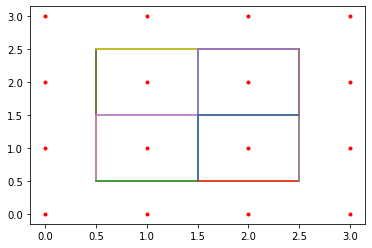

In [5]:
class Voronoi:
    def __init__(self, points):
        # Super Triangle
        self.supertr = self.superTriang(points)
        # List that holds all triangles in delaunay
        self.triang = [self.supertr]
        # Reverse triang list
        self.points = collections.defaultdict(list)

        self.vor_cells = []

        # Add supertr points to triangulation
        for p in self.supertr.getPoints():
            self.points[p].append(self.supertr)

        # Add points one by one
        for p in points:
            self.addPoint(Point(p[0],p[1]))

        # Remove triangles from supertr
        for p in self.supertr.getPoints():
            for t in self.points[p]:
                try:
                    self.triang.remove(t)
                except:
                    print(f'Triangle {t} does not exist')
            del self.points[p]
        
        print(f"number of points: {len(self.points)}")
        
        for p, triangles in self.points.items():
            # t_center_point = lambda t: Point(t.ccenter[0], t.ccenter[1])
            cell_points = []
            for t in triangles:
                share = bool(set(t.getPoints()) & set(self.supertr.getPoints()))
                if not share:
                    cell_points.append(Point(t.ccenter[0], t.ccenter[1]))

            # cell_points = list(map(t_center_point, triangles))
            self.vor_cells.append(Cell(cell_points, p))
        

    def addPoint(self, point):
        badT = []
        for t in self.triang:
            if point.inTriagCercumC(t):
                badT.append(t)

        # Find convex hull of badT
        polygon = []
        for t in badT:
            for edge in t.getEdges():
                if edge in polygon:
                    polygon.remove(edge)
                else:
                    polygon.append(edge)

        for t in badT:
            self.triang.remove(t)

            for p in t.getPoints():
                self.points[p].remove(t)

        for edge in polygon:
            edge = list(edge)
            t = Triangle(point, edge[0], edge[1])
            self.triang.append(t)
            for p in t.getPoints():
                self.points[p].append(t)

    def superTriang(self, points):
        points = np.array(points)
        xmax = np.amax(points[:,0])
        ymax = np.amax(points[:,1])
        xmin = np.amin(points[:,0])
        ymin = np.amin(points[:,1])
        return Triangle(
            Point(2*xmin-xmax, ymin-1),
            Point(2*xmax-xmin, ymin-1),
            Point(xmax-(xmax-xmin)/2, 2*ymax)
        )


    def draw(self):
        plt.figure()
        # plt.grid(True, which='both')
        # for c in self.vor_cells:
        #     c.draw()

        for t1 in self.triang:
            for t2 in self.triang:
                if t1.shareSide(t2):
                    c1 = t1.ccenter
                    c2 = t2.ccenter
                    x = [c1[0], c2[0]]
                    y = [c1[1], c2[1]]
                    plt.plot(x, y)

        for p in self.points.keys():
                p.draw()
            # t.draw()

        # plt.autoscale()
        plt.show()

# points = np.random.randint(100, 200, size=(100, 2))
# points = np.array([[0,0], [10,0], [10,10], [0,10]])
# print(points)
points = [[p1, p2] for p1 in range(4) for p2 in range(4)]

vor = Voronoi(points)
# print(vor.points)
vor.draw()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars


Triangle '(165, 100), (1, 99), (298, 99)' does not exist
Triangle '(101, 191), (149.5, 396), (1, 99)' does not exist
Triangle '(197, 185), (149.5, 396), (298, 99)' does not exist
number of points: 99


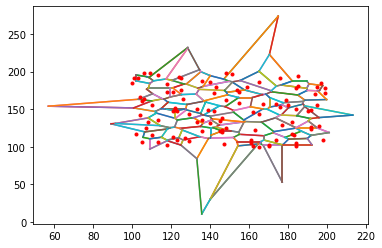

In [6]:
# t = Triangle(Point(0,0), Point(3,0), Point(1,4))
t1 = Triangle(Point(10,2), Point(3,0), Point(1,4))
p1 = Point(1, 1)
p2 = Point(2, 1)
p3 = Point(2, 0)
p4 = Point(1, 0)
c = Point(1.5, 0.5)

# c = Cell([p1, p2, p3, p4], c)
# c.draw()

# print(t.cradius)
# print(t.ccenter)

# print("in triag t")
# print(p1.inTriagCercumC(t))
# print(p2.inTriagCercumC(t))
# print("in triag T1")
# print(p1.inTriagCercumC(t1))
# print(p2.inTriagCercumC(t1))



points = np.random.randint(100, 200, size=(100, 2))
# points = np.array([[0,0], [10,0], [10,10], [0,10]])
# print(points)
# points = [[p1, p2] for p1 in range(4) for p2 in range(4)]

vor = Voronoi(points)
# print(vor.points)
vor.draw()

# plt.figure()
# plt.grid(True, which='both')
# t.draw()
# t1.draw()
# plt.axhline(y=0, color='k')
# p1.draw()
# p2.draw()
# plt.axvline(x=0, color='k')